In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim*8,im_dim),
            nn.Sigmoid(),
        )
    def forward(self, noise):
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        return self.gen

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [ ]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(negative_slope=0.2),
    )

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1),
        )

    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)




  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
device = 'cuda'

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake_noise = get_noise(num_images,z_dim,device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    
    
    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = get_noise(num_images,z_dim,device=device)
    fake_noise = gen(noise)
    disc_fake_pred = disc(fake_noise)
    gen_loss = criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
    return gen_loss

In [ ]:

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen,disc,criterion,cur_batch_size,z_dim,device)
            gen_loss.backward()
            gen_opt.step()
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")
        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            #fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            #fake = gen(fake_noise)
            #show_tensor_images(fake)
            #show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1



  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 1.3880867052078256, discriminator loss: 0.41925957834720645


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 1.668566526889802, discriminator loss: 0.30028375130891816


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 1.959324582576752, discriminator loss: 0.1741839507520198


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 1.7683934478759762, discriminator loss: 0.1949440966844561


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 1.7278085255622873, discriminator loss: 0.19442812308669088


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 2.014976006269454, discriminator loss: 0.15290577177703377


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 2.3937902240753184, discriminator loss: 0.12668093612790096


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 2.7024712367057804, discriminator loss: 0.12406240332126625


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 3.173227486133573, discriminator loss: 0.10126776205003256


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 3.417671162128448, discriminator loss: 0.08130290301144114


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 3.752992695808412, discriminator loss: 0.07852757691591977


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 3.722099542140963, discriminator loss: 0.07627186875790355


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 4.000880888938901, discriminator loss: 0.06402512470632786


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 3.9995368876457214, discriminator loss: 0.05612198292464013


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 4.059642785072325, discriminator loss: 0.05460877505317336


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 4.110595849990845, discriminator loss: 0.055530363883823146


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 4.120031257629396, discriminator loss: 0.056098670102655915


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 4.127713983058929, discriminator loss: 0.06192196243256335


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 4.115702560901641, discriminator loss: 0.06338186610490078


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 4.170740735530848, discriminator loss: 0.07108791670203217


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 4.104406780719757, discriminator loss: 0.06785478420555587


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 4.07264266872406, discriminator loss: 0.06970762199908508


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 3.8456175985336287, discriminator loss: 0.07794938928633935


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 3.807990967273711, discriminator loss: 0.08241829316318043


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 3.764896757125856, discriminator loss: 0.08643056093901391


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 3.865275774955749, discriminator loss: 0.08410475219786165


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 4.0007845621109, discriminator loss: 0.08532053656131032


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 3.774897728919983, discriminator loss: 0.0901627577766776


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 3.604588718891145, discriminator loss: 0.1117205957621336


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 3.5569542384147645, discriminator loss: 0.1205920485481621


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 3.6075638499259948, discriminator loss: 0.11188043212145571


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 3.649201321601864, discriminator loss: 0.11700642426311961


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 3.5753578824996937, discriminator loss: 0.13952511746436347


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 3.3425003304481495, discriminator loss: 0.15259517423808575


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 3.4094332404136654, discriminator loss: 0.1492799640595913


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 3.449010145664213, discriminator loss: 0.14788225786387935


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 3.325320384502411, discriminator loss: 0.15879710181057446


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 3.4100316348075856, discriminator loss: 0.15976193442940706


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 3.279194536685943, discriminator loss: 0.1589689846336842


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 3.196360680103302, discriminator loss: 0.16780991670489334


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 3.2949592690467813, discriminator loss: 0.1666075945943595


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 3.1310872564315804, discriminator loss: 0.17254772247374048


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 3.058413105487824, discriminator loss: 0.17874279318749897


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 3.0679690880775445, discriminator loss: 0.15877016857266427


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 3.085533138751984, discriminator loss: 0.1815309383720159


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 3.128981346130373, discriminator loss: 0.1710731254369021


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50, step 23500: Generator loss: 3.015677835941313, discriminator loss: 0.17845046967267972


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51, step 24000: Generator loss: 2.979828438282011, discriminator loss: 0.19013891451060774


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52, step 24500: Generator loss: 2.8435225605964645, discriminator loss: 0.2082705783396958


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53, step 25000: Generator loss: 2.9014298634529063, discriminator loss: 0.18622358874976633


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54, step 25500: Generator loss: 2.9482596273422264, discriminator loss: 0.19608000770211234


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55, step 26000: Generator loss: 2.8799669785499566, discriminator loss: 0.18802020956575866


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56, step 26500: Generator loss: 2.9095718379020674, discriminator loss: 0.18624378289282328


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57, step 27000: Generator loss: 2.880731247425079, discriminator loss: 0.1874608987867832


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58, step 27500: Generator loss: 2.9107924656867974, discriminator loss: 0.20229090183973306


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59, step 28000: Generator loss: 2.6779756336212186, discriminator loss: 0.2161729442030193


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60, step 28500: Generator loss: 2.6733138904571527, discriminator loss: 0.21608931769430634


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61, step 29000: Generator loss: 2.780358341217042, discriminator loss: 0.2028838180303576


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62, step 29500: Generator loss: 2.7009208421707154, discriminator loss: 0.2272432153671979


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63, step 30000: Generator loss: 2.493438837528229, discriminator loss: 0.23749257695674875


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65, step 30500: Generator loss: 2.5608049840927123, discriminator loss: 0.2353018017411232


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66, step 31000: Generator loss: 2.6218417320251457, discriminator loss: 0.2182515046745539


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67, step 31500: Generator loss: 2.798048185825347, discriminator loss: 0.21245864756405347


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68, step 32000: Generator loss: 2.54140169429779, discriminator loss: 0.23719523751735688


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69, step 32500: Generator loss: 2.5377034211158755, discriminator loss: 0.22662653905153282


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70, step 33000: Generator loss: 2.6143956308364884, discriminator loss: 0.23015472498536116


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71, step 33500: Generator loss: 2.4511899356842037, discriminator loss: 0.25747221136093124


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72, step 34000: Generator loss: 2.578501836299894, discriminator loss: 0.21911055150628092


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 73, step 34500: Generator loss: 2.508308090448378, discriminator loss: 0.24237770742177958


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 74, step 35000: Generator loss: 2.3842609977722153, discriminator loss: 0.26593343478441234


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 75, step 35500: Generator loss: 2.4509774408340435, discriminator loss: 0.2373512673377991


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 76, step 36000: Generator loss: 2.3584447500705723, discriminator loss: 0.266789112508297


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 77, step 36500: Generator loss: 2.3203842968940736, discriminator loss: 0.28916739034652694


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 78, step 37000: Generator loss: 2.357788319349286, discriminator loss: 0.2608941292166708


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 79, step 37500: Generator loss: 2.351834354162218, discriminator loss: 0.27301972818374626


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 81, step 38000: Generator loss: 2.2784524383544946, discriminator loss: 0.2723174800574778


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 82, step 38500: Generator loss: 2.3142802920341494, discriminator loss: 0.2572194760441778


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 83, step 39000: Generator loss: 2.3025233120918274, discriminator loss: 0.2695216931402684


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 84, step 39500: Generator loss: 2.2323747134208682, discriminator loss: 0.27884348353743554


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 85, step 40000: Generator loss: 2.1152473700046546, discriminator loss: 0.31059461379051223


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 86, step 40500: Generator loss: 2.0627073223590857, discriminator loss: 0.3142721844017504


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 87, step 41000: Generator loss: 2.1827290544509887, discriminator loss: 0.2832349318861962


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 88, step 41500: Generator loss: 2.11561337852478, discriminator loss: 0.3093286971449851


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 89, step 42000: Generator loss: 2.0189358749389643, discriminator loss: 0.31809654235839846


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 90, step 42500: Generator loss: 2.0565742826461797, discriminator loss: 0.31023806178569796


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 91, step 43000: Generator loss: 2.0659488270282753, discriminator loss: 0.30684059649705875


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 92, step 43500: Generator loss: 2.0535892002582554, discriminator loss: 0.30968184140324595


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 93, step 44000: Generator loss: 2.0373112249374405, discriminator loss: 0.31254486083984373


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 94, step 44500: Generator loss: 2.0551625967025755, discriminator loss: 0.3067727214396001


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 95, step 45000: Generator loss: 1.9910052354335777, discriminator loss: 0.3209669448137284


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 97, step 45500: Generator loss: 1.9502515387535104, discriminator loss: 0.3316824981570244


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 98, step 46000: Generator loss: 1.9760945153236398, discriminator loss: 0.3206606244742868


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 99, step 46500: Generator loss: 2.0688662965297717, discriminator loss: 0.31673537686467157


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 100, step 47000: Generator loss: 2.0862218716144567, discriminator loss: 0.3025382050275803


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 101, step 47500: Generator loss: 2.064173220396041, discriminator loss: 0.30361973968148254


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 102, step 48000: Generator loss: 1.9969523613452904, discriminator loss: 0.32834650799632076


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 103, step 48500: Generator loss: 2.0043974521160126, discriminator loss: 0.31227619662880884


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 104, step 49000: Generator loss: 1.989360816240311, discriminator loss: 0.333268439799547


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 105, step 49500: Generator loss: 1.9727068514823936, discriminator loss: 0.3150990564823149


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 106, step 50000: Generator loss: 1.8938840143680575, discriminator loss: 0.34073239797353755


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 107, step 50500: Generator loss: 1.8743498568534838, discriminator loss: 0.33702847954630866


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 108, step 51000: Generator loss: 1.8677388889789586, discriminator loss: 0.3392851178944114


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 109, step 51500: Generator loss: 1.9075509450435648, discriminator loss: 0.3272546034753324


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 110, step 52000: Generator loss: 1.9028252069950098, discriminator loss: 0.3316294788420199


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 111, step 52500: Generator loss: 1.9344746465682985, discriminator loss: 0.3142664389312268


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 113, step 53000: Generator loss: 1.9328679664134982, discriminator loss: 0.3297691234052182


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 114, step 53500: Generator loss: 1.9506051552295702, discriminator loss: 0.32326929917931546


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 115, step 54000: Generator loss: 1.9430796370506278, discriminator loss: 0.3241190462112427


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 116, step 54500: Generator loss: 1.8515301921367653, discriminator loss: 0.33828402045369155


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 117, step 55000: Generator loss: 1.8887347621917738, discriminator loss: 0.34426153957843797


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 118, step 55500: Generator loss: 1.8435745697021473, discriminator loss: 0.34094933867454547


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 119, step 56000: Generator loss: 1.867158604621888, discriminator loss: 0.3330473868846895


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 120, step 56500: Generator loss: 1.8475605490207663, discriminator loss: 0.3380909895300864


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 121, step 57000: Generator loss: 1.9324964864254, discriminator loss: 0.3204991040825843


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 122, step 57500: Generator loss: 1.8384058213233967, discriminator loss: 0.33486872830986997


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 123, step 58000: Generator loss: 1.810804909944535, discriminator loss: 0.34591914686560604


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 124, step 58500: Generator loss: 1.919451351881026, discriminator loss: 0.32307273945212334


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 125, step 59000: Generator loss: 1.8514468624591827, discriminator loss: 0.34162411502003653


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 126, step 59500: Generator loss: 1.8839188568592067, discriminator loss: 0.33246870470047013


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 127, step 60000: Generator loss: 1.9449070270061508, discriminator loss: 0.319442628443241


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 128, step 60500: Generator loss: 1.897895922660826, discriminator loss: 0.3466037793755529


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 130, step 61000: Generator loss: 1.864490627288819, discriminator loss: 0.34072875514626516


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 131, step 61500: Generator loss: 1.8344018225669863, discriminator loss: 0.34182891342043925


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 132, step 62000: Generator loss: 1.7802029161453239, discriminator loss: 0.3667892984747885


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 133, step 62500: Generator loss: 1.6790993642807008, discriminator loss: 0.3837220220267773


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 134, step 63000: Generator loss: 1.6491072313785555, discriminator loss: 0.3941173534989357


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 135, step 63500: Generator loss: 1.585062161922455, discriminator loss: 0.4037725976109504


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 136, step 64000: Generator loss: 1.683886256694793, discriminator loss: 0.3706173832416535


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 137, step 64500: Generator loss: 1.6518693478107458, discriminator loss: 0.3882991799116131


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 138, step 65000: Generator loss: 1.6168201632499688, discriminator loss: 0.3974373819231987


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 139, step 65500: Generator loss: 1.6271502768993364, discriminator loss: 0.39028870606422433


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 140, step 66000: Generator loss: 1.6495066831111918, discriminator loss: 0.38791517096757905


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 141, step 66500: Generator loss: 1.604729948997498, discriminator loss: 0.3999934515953069


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 142, step 67000: Generator loss: 1.6147959504127516, discriminator loss: 0.38698561900854106


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 143, step 67500: Generator loss: 1.6163895299434665, discriminator loss: 0.39511909943819057


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 144, step 68000: Generator loss: 1.750641364097595, discriminator loss: 0.352280078500509


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 146, step 68500: Generator loss: 1.7118380331993093, discriminator loss: 0.364300072014332


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 147, step 69000: Generator loss: 1.6478891036510461, discriminator loss: 0.37936631488800115


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 148, step 69500: Generator loss: 1.5884022569656369, discriminator loss: 0.38074749547243103


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 149, step 70000: Generator loss: 1.597826250076294, discriminator loss: 0.3791309997439388


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 150, step 70500: Generator loss: 1.6220452854633325, discriminator loss: 0.37858276158571236


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 151, step 71000: Generator loss: 1.5375200917720808, discriminator loss: 0.413812181830406


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 152, step 71500: Generator loss: 1.5664815301895147, discriminator loss: 0.4100647925138472


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 153, step 72000: Generator loss: 1.5887516636848455, discriminator loss: 0.3943869885206223


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 154, step 72500: Generator loss: 1.512814450979232, discriminator loss: 0.4254571899175645


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 155, step 73000: Generator loss: 1.551632888078691, discriminator loss: 0.400296521127224


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 156, step 73500: Generator loss: 1.6302808744907369, discriminator loss: 0.3852238333225252


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 157, step 74000: Generator loss: 1.6461135106086726, discriminator loss: 0.3834895892143251


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 158, step 74500: Generator loss: 1.54132934498787, discriminator loss: 0.4121997019648551


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 159, step 75000: Generator loss: 1.4987484667301176, discriminator loss: 0.41200608140230155


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 160, step 75500: Generator loss: 1.5414598226547245, discriminator loss: 0.4089628025889397


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 162, step 76000: Generator loss: 1.5593853242397304, discriminator loss: 0.4006373441219331


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 163, step 76500: Generator loss: 1.6130691132545456, discriminator loss: 0.39121531957387895


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 164, step 77000: Generator loss: 1.5794323067665101, discriminator loss: 0.3933244899511337


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 165, step 77500: Generator loss: 1.5919724779129019, discriminator loss: 0.3955730262994763


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 166, step 78000: Generator loss: 1.5602062976360334, discriminator loss: 0.4001119113564496


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 167, step 78500: Generator loss: 1.5403004119396204, discriminator loss: 0.38877483946084945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 168, step 79000: Generator loss: 1.59909131360054, discriminator loss: 0.3804864165186882


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 169, step 79500: Generator loss: 1.6282902441024778, discriminator loss: 0.37831868332624424


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 170, step 80000: Generator loss: 1.5109507002830507, discriminator loss: 0.41594818764924985


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 171, step 80500: Generator loss: 1.4699722204208385, discriminator loss: 0.4230667575001715


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 172, step 81000: Generator loss: 1.5195253834724431, discriminator loss: 0.4133126702308654


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 173, step 81500: Generator loss: 1.4417879722118383, discriminator loss: 0.44875209027528756


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 174, step 82000: Generator loss: 1.4431729934215558, discriminator loss: 0.4353769701719285


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 175, step 82500: Generator loss: 1.4057111613750455, discriminator loss: 0.4499597101807595


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 176, step 83000: Generator loss: 1.386430612087249, discriminator loss: 0.44408593827486004


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 178, step 83500: Generator loss: 1.428501879692078, discriminator loss: 0.43779434961080566


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 179, step 84000: Generator loss: 1.3751508374214167, discriminator loss: 0.45349471890926374


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 180, step 84500: Generator loss: 1.48988425564766, discriminator loss: 0.41076495599746704


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 181, step 85000: Generator loss: 1.5138187685012825, discriminator loss: 0.41230802017450313


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 182, step 85500: Generator loss: 1.5149041326045993, discriminator loss: 0.40097331941127773


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 183, step 86000: Generator loss: 1.4484546835422514, discriminator loss: 0.424947320818901


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 184, step 86500: Generator loss: 1.4359360952377322, discriminator loss: 0.4367954850196836


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 185, step 87000: Generator loss: 1.4205185291767144, discriminator loss: 0.4341554713845252


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 186, step 87500: Generator loss: 1.4207969965934772, discriminator loss: 0.43582515031099356


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 187, step 88000: Generator loss: 1.4264915399551386, discriminator loss: 0.436454366564751


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 188, step 88500: Generator loss: 1.409303337097167, discriminator loss: 0.44720509153604476


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 189, step 89000: Generator loss: 1.4084998459815985, discriminator loss: 0.44688562935590764


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 190, step 89500: Generator loss: 1.4436756207942953, discriminator loss: 0.4308762442469594


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 191, step 90000: Generator loss: 1.4201873867511754, discriminator loss: 0.4452641904354093


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 192, step 90500: Generator loss: 1.4711947677135453, discriminator loss: 0.4221856098771098


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 194, step 91000: Generator loss: 1.428033621549606, discriminator loss: 0.41654689294099856


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 195, step 91500: Generator loss: 1.4844020333290104, discriminator loss: 0.41348618692159633


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 196, step 92000: Generator loss: 1.4667331044673917, discriminator loss: 0.4071700478196146


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 197, step 92500: Generator loss: 1.375749848127365, discriminator loss: 0.49273216992616625


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 198, step 93000: Generator loss: 1.1570384173393253, discriminator loss: 0.5071535967588426


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 199, step 93500: Generator loss: 1.5940783216953283, discriminator loss: 0.38569352138042395


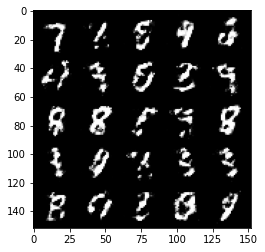

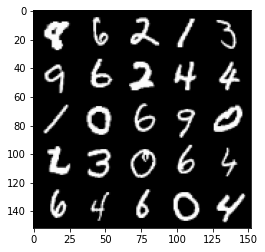

In [ ]:
fake_noise = get_noise(cur_batch_size, z_dim, device=device)
fake = gen(fake_noise)
show_tensor_images(fake)
show_tensor_images(real)